In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM
from tqdm.notebook import tqdm
from KMlib.metrics import total_score
from KMlib.naive_processing import get_submit_data
from KMlib.plot_metrics import plot_loss,plot_test
from KMlib.processing import pr_scaling,x_scaling,Processer,get_test_data

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [4]:
# change file here
df_rich = pd.read_csv(r'../data/the_rich_r_6.csv',index_col = 0)
df_poor = pd.read_csv(r'../data/the_poor_r_6.csv',index_col = 0)
## get true test value
df = pd.read_csv(r'../data/complete_feature.csv',index_col = 0)
purchase_true = df.loc["2014-08-01":"2014-08-30"].iloc[:, 0]
redeem_true = df.loc["2014-08-01":"2014-08-30"].iloc[:, 1]
df_train = df.loc["2014-04-01":"2014-08-31"]
col = ['total_purchase_amt', 'consume_amt', 'transfer_amt','month', 'day', 'weekday', 'dis_to_nowork',
      'dis_from_nowork', 'dis_to_work',
       'dis_from_work', 'dis_from_holiday', 'dis_to_holiendday',
       'dis_from_holiendday', 'dis_from_endofweek', 'dis_from_purchase_peak',
       'dis_from_purchase_valley', 'user_id']  # user id is user count
df_train = df_train[col]

In [5]:
df_poor_train = df_poor.loc[:"2014-07-31",col]
df_rich_train = df_rich.loc[:"2014-07-31",col]
_,_,_,pp_scaler,prc_scaler,prt_scaler = pr_scaling(df_poor_train)
_,_,_,rp_scaler,rrc_scaler,rrt_scaler = pr_scaling(df_rich_train)
px_data,px_scaler =  x_scaling(df_poor_train)
rx_data,rx_scaler =  x_scaling(df_rich_train)

In [26]:
WINDOW_SIZE = 30
BATCH_SIZE = 16
SHUFFLE_BUFFER = 1000 
number_pred = 30
number_shift = 1
input_dimension = 3
L= Processer(WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER,number_pred,number_shift,input_dimension)
# Train-Valid Split 
px_train,px_valid = L.train_valid_split(px_data)
rx_train,rx_valid = L.train_valid_split(rx_data)

In [27]:
p_col = list(df_poor.columns).index('total_purchase_amt')
c_col = list(df_poor.columns).index('consume_amt')
t_col = list(df_poor.columns).index('transfer_amt')
pp_tensor_train,pp_tensor_valid = L.get_tensor_dataset(px_train,y_col = p_col)
prc_tensor_train,prc_tensor_valid = L.get_tensor_dataset(px_train,y_col = c_col)
prt_tensor_train,prt_tensor_valid = L.get_tensor_dataset(px_train,y_col = t_col)
rp_tensor_train,rp_tensor_valid = L.get_tensor_dataset(rx_train,y_col = p_col)
rrc_tensor_train,rrc_tensor_valid = L.get_tensor_dataset(rx_train,y_col = c_col)
rrt_tensor_train,rrt_tensor_valid = L.get_tensor_dataset(rx_train,y_col = t_col)


### Learning rate selecting

In [46]:
def get_p_model(train,valid, epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True,
                             input_shape = [WINDOW_SIZE, px_train.shape[1]]),dtype = 'float64'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
        ])
    optimizer = tf.keras.optimizers.Adam(lr=1e-8)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda x:1e-8 * 10**(x/20))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0,
                        validation_data=valid,callbacks = [lr_decay])
    return model, history
def get_r_model(train,valid, epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,
                             input_shape = [WINDOW_SIZE, px_train.shape[1]]),dtype = 'float64'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False),dtype = 'float64'),
    tf.keras.layers.Dense(40, activation="relu"),
    tf.keras.layers.Dense(30)
        ])
    optimizer = tf.keras.optimizers.Adam(lr=1e-8)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda x:1e-8 * 10**(x/20))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0,
                        validation_data=valid,callbacks = [lr_decay])
    return model, history

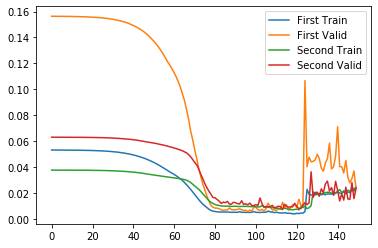

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(7)
np.random.seed(7)
epochs = 150
pp_model,pp_history =get_p_model(pp_tensor_train ,pp_tensor_valid,epochs = epochs )
rp_model,rp_history =get_p_model(rp_tensor_train ,rp_tensor_valid,epochs = epochs)
plot_loss(pp_history, rp_history)

[1e-08, 0.1, 0, 0.08]

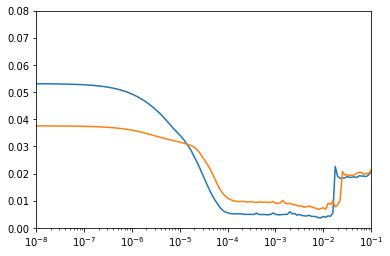

In [17]:
plt.semilogx(pp_history.history["lr"], pp_history.history["loss"])
plt.semilogx(rp_history.history["lr"], rp_history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 0.08])

## Model developing

In [73]:
def get_p_model(train,valid, epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,
                             input_shape = [WINDOW_SIZE, px_train.shape[1]]),dtype = 'float64'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False),dtype = 'float64'),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
        ])
    optimizer = tf.keras.optimizers.Adam(lr=2e-5)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda x:2e-5 * 10**(-x/1000))
    model.compile(loss="mse", optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0,
                        validation_data=valid,callbacks = [lr_decay])
    return model, history
def get_r_model(train,valid, epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True,
                             input_shape = [WINDOW_SIZE, px_train.shape[1]]),dtype = 'float64'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
        ])
    optimizer = tf.keras.optimizers.Adam(lr=2e-5)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda x:2e-5 * 10**(-x/900))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0,
                        validation_data=valid,callbacks = [lr_decay])
    return model, history


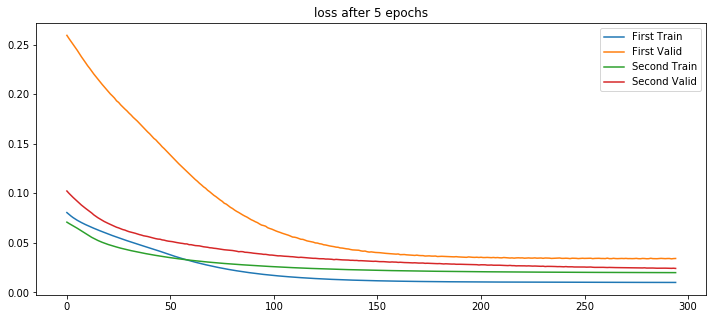

In [79]:
tf.keras.backend.clear_session()
epochs = 300
pp_model,pp_history =get_p_model(pp_tensor_train ,pp_tensor_valid,epochs = epochs)
tf.keras.backend.clear_session()
rp_model,rp_history =get_p_model(rp_tensor_train ,rp_tensor_valid,epochs = epochs)
plot_loss(pp_history, rp_history)

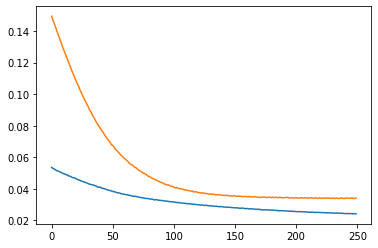

In [80]:
plt.plot(rp_history.history['val_loss'][50:])
plt.plot(pp_history.history['val_loss'][50:])

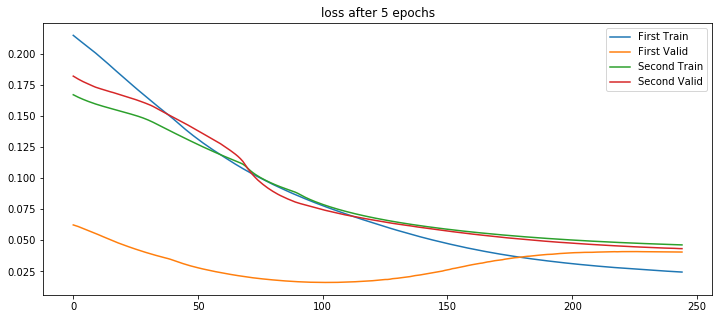

In [81]:
tf.keras.backend.clear_session()
epochs = 250
prc_model,prc_history =get_r_model(prc_tensor_train,prc_tensor_valid,epochs = epochs)
tf.keras.backend.clear_session()
prt_model,prt_history =get_r_model(prt_tensor_train,prt_tensor_valid,epochs = epochs)
plot_loss(prc_history,prt_history)

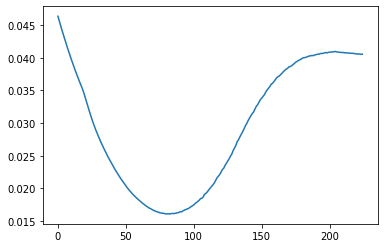

In [82]:
plt.plot(prc_history.history['val_loss'][25:])

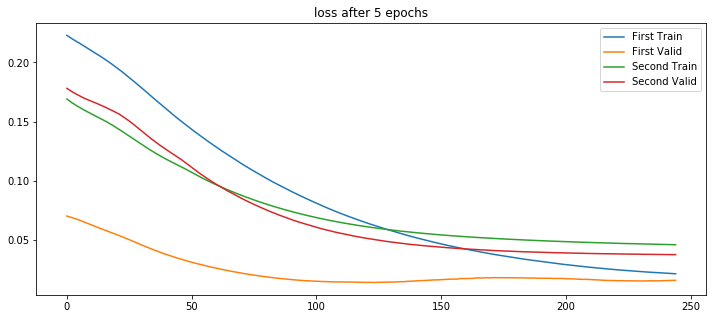

In [83]:
tf.keras.backend.clear_session()
tf.random.set_seed(7)
np.random.seed(7)
epochs = 250
rrc_model,rrc_history =get_r_model(rrc_tensor_train,rrc_tensor_valid,epochs = epochs)
tf.keras.backend.clear_session()
rrt_model,rrt_history =get_r_model(rrt_tensor_train,rrt_tensor_valid,epochs =epochs)
plot_loss(rrc_history,rrt_history)

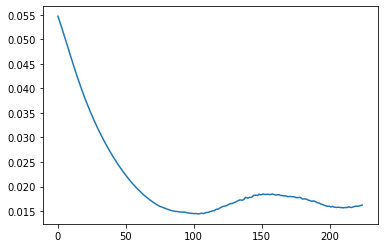

In [84]:
plt.plot(rrc_history.history['val_loss'][25:])

In [91]:
# get test data
df_poor_test = df_poor_train[-WINDOW_SIZE:]
df_rich_test = df_rich_train[-WINDOW_SIZE:]
px_test = px_scaler.transform(df_poor_test.values)
rx_test = rx_scaler.transform(df_rich_test.values)

In [92]:
pp_pred = pp_scaler.inverse_transform(pp_model.predict(px_test[np.newaxis,...]).reshape(1,30)).reshape(30,)
prc_pred = prc_scaler.inverse_transform(prc_model.predict(px_test[np.newaxis,...]).reshape(1,30)).reshape(30,)
prt_pred = prt_scaler.inverse_transform(prt_model.predict(px_test[np.newaxis,...]).reshape(1,30)).reshape(30,)
rp_pred = rp_scaler.inverse_transform(rp_model.predict(rx_test[np.newaxis,...]).reshape(1,30)).reshape(30,)
rrc_pred = rrc_scaler.inverse_transform(rrc_model.predict(rx_test[np.newaxis,...]).reshape(1,30)).reshape(30,)
rrt_pred = rrt_scaler.inverse_transform(rrt_model.predict(rx_test[np.newaxis,...]).reshape(1,30)).reshape(30,)

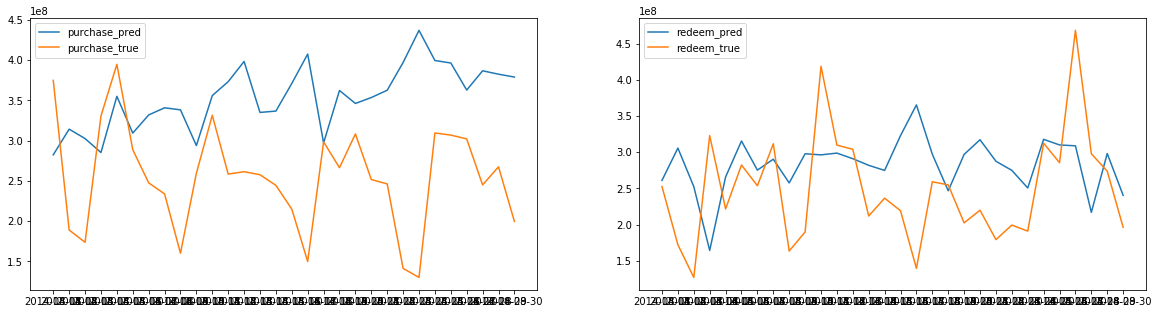

63.77921619879416

In [93]:
purchase_pred = rp_pred + pp_pred 
redeem_pred = rrc_pred + rrt_pred + prt_pred + prc_pred
plot_test(purchase_pred,purchase_true,redeem_pred,redeem_true)
total_score(purchase_pred,purchase_true,redeem_pred,redeem_true)